In [1]:
%matplotlib inline

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
import time

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Import everything needed to edit/save/watch video clips
#import imageio
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data_dir = './data'

In [3]:
import utils

In [21]:
# Common params

use_hog = True
use_hist = True
use_spatial = True

colorspace = 'YUV'

#HOG SETTINGS
window=64 #This is the size of the original training images. DO NOT CHANGE.
hog_channel = 'ALL'
orient = 11
pix_per_cell=16
cell_per_block = 2

cells_per_step=1

#COLOR FEATURE SETTINGS
# Size (scale) over which to look for color based features. 
color_feature_size=(window, window)
spatial_size = (16, 16)
hist_bins = 32
hist_range = (0., 1.)

#TRAINING ONLY SETTINGS
sample_size = None

#TEST ONLY WINDOW SETTINGS
ystart = 400
ystop = 656
scale = 1.0


In [5]:
# Divide up into cars and notcars
cars = glob.glob(data_dir+'/vehicles/*/*.png')
notcars = glob.glob(data_dir+'/non-vehicles/*/*.png')

print(len(cars))
print(len(notcars))

8792
8968


Colorspace: RGB
 > Reader: mpimg
Max: 0.5 Min: -0.5


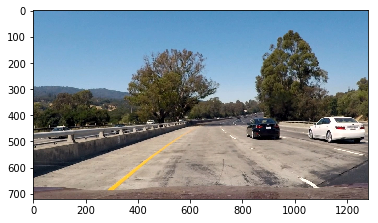

 > Reader: cv2
Max: 0.5 Min: -0.5


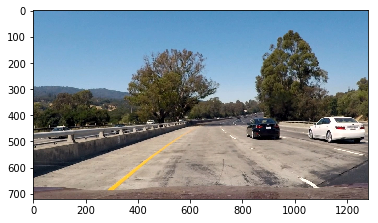

Colorspace: HLS
 > Reader: mpimg
Max: 0.5 Min: -0.5


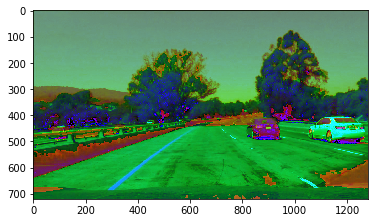

 > Reader: cv2
Max: 0.5 Min: -0.5


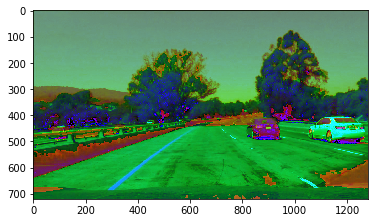

Colorspace: YCrCb
 > Reader: mpimg
Max: 0.5 Min: -0.5


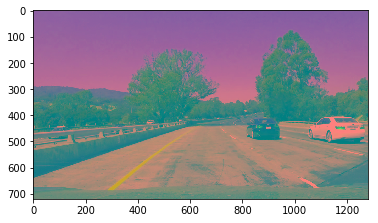

 > Reader: cv2
Max: 0.5 Min: -0.5


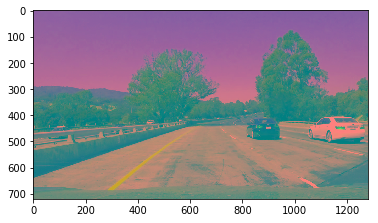

Colorspace: HSV
 > Reader: mpimg
Max: 0.5 Min: -0.5


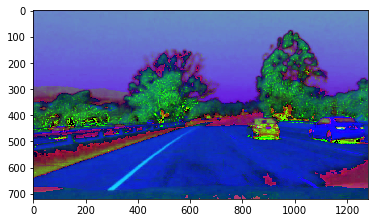

 > Reader: cv2
Max: 0.5 Min: -0.5


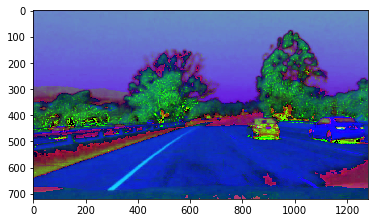

Colorspace: RGB
 > Reader: mpimg
Max: 0.154901960784 Min: -0.449019607843


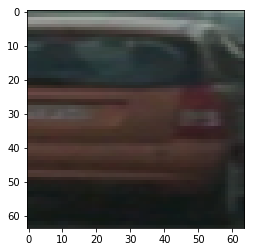

 > Reader: cv2
Max: 0.154901960784 Min: -0.449019607843


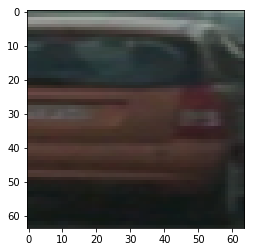

Colorspace: HLS
 > Reader: mpimg
Max: 0.201960784314 Min: -0.5


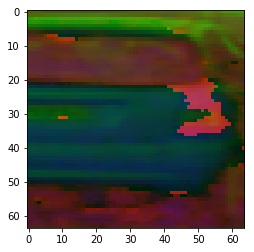

 > Reader: cv2
Max: 0.201960784314 Min: -0.5


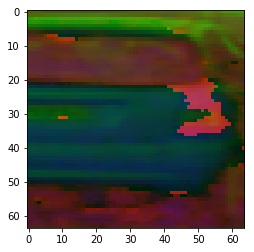

Colorspace: YCrCb
 > Reader: mpimg
Max: 0.139215686275 Min: -0.425490196078


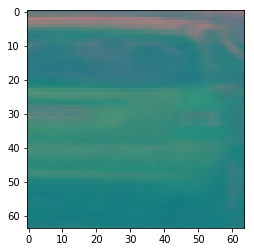

 > Reader: cv2
Max: 0.139215686275 Min: -0.425490196078


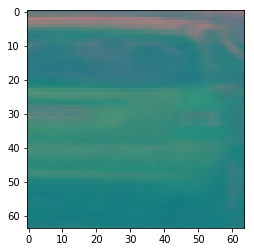

Colorspace: HSV
 > Reader: mpimg
Max: 0.201960784314 Min: -0.5


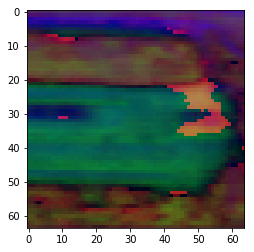

 > Reader: cv2
Max: 0.201960784314 Min: -0.5


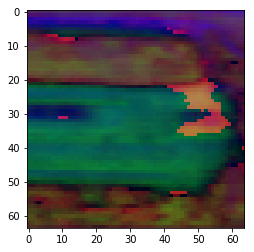

Colorspace: RGB
 > Reader: mpimg
Max: -0.0137254901961 Min: -0.241176470588


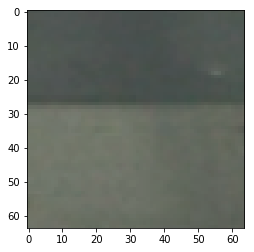

 > Reader: cv2
Max: -0.0137254901961 Min: -0.241176470588


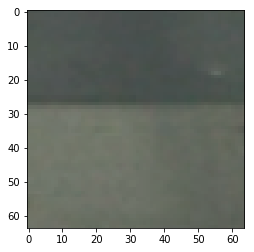

Colorspace: HLS
 > Reader: mpimg
Max: -0.0333333333333 Min: -0.492156862745


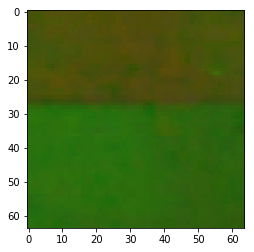

 > Reader: cv2
Max: -0.0333333333333 Min: -0.492156862745


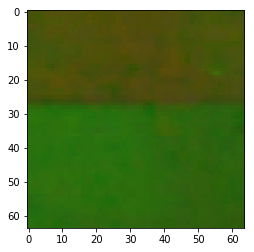

Colorspace: YCrCb
 > Reader: mpimg
Max: 0.00588235294118 Min: -0.213725490196


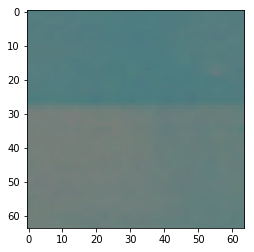

 > Reader: cv2
Max: 0.00588235294118 Min: -0.213725490196


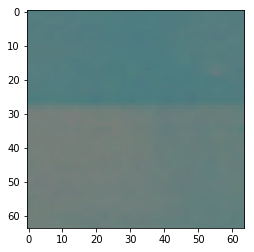

Colorspace: HSV
 > Reader: mpimg
Max: -0.0137254901961 Min: -0.488235294118


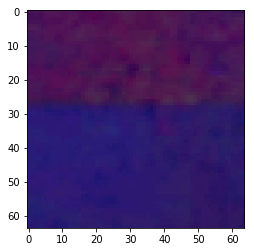

 > Reader: cv2
Max: -0.0137254901961 Min: -0.488235294118


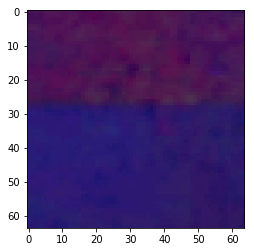

In [6]:
# Make sure normalizing works as expected.

def show_norm_img(norm):
    plt.imshow(((norm + 0.5) * 255.).astype(np.uint8))
    plt.show()

test_images = [
    ('jpeg', 'test_images/test1.jpg'),
    ('png', cars[2]),
    ('png', notcars[3])
]
test_cspaces = ['RGB', 'HLS', 'YCrCb', 'HSV']
test_readers = [('mpimg', mpimg), ('cv2', cv2) ]
test_scale = 1.

for itype, path in test_images:
    for c in test_cspaces:
        print ("Colorspace:", c)
        for r_str, r in test_readers:
            print (" > Reader:", r_str)
            img = r.imread(path)
            norm = utils.prepare_image(img, colorspace=c, reader=r_str)
            print('Max:', norm.max(), 'Min:', norm.min())
            show_norm_img(norm)


In [7]:
print("Training SVM..")

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
if sample_size:
    print("Subsampling the first {} samples for training..".format(sample_size))
    cars = cars[0:sample_size]
    notcars = notcars[0:sample_size]

t=time.time()
car_features = utils.extract_features(cars, colorspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range, debug=False)
notcar_features = utils.extract_features(notcars, colorspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
print(X)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Training SVM..
48.76 Seconds to extract HOG features...
[[ 0.00242438  0.00932725  0.04195782 ...,  0.          0.          0.        ]
 [ 0.03338262  0.03786436  0.03142006 ...,  0.          0.          0.        ]
 [ 0.00213431  0.00232863  0.00244444 ...,  0.          0.          0.        ]
 ..., 
 [ 0.00303384  0.00432824  0.0072536  ...,  0.          0.          0.        ]
 [ 0.01599712  0.0226177   0.01456121 ...,  0.          0.          0.        ]
 [ 0.01252456  0.00348879  0.00637435 ...,  0.          0.          0.        ]]
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2052
2.68 Seconds to train SVC...
Test Accuracy of SVC =  0.9918
My SVC predicts:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  0.]
0.00171 Seconds to predict 10 labels with SVC


In [8]:
def find_cars(img, debug=False):

    draw_img = np.copy(img)
    
    img = utils.prepare_image(img, colorspace=colorspace)

    img = utils.get_subimg(img, ystart, ystop, scale)

    if use_hog:
        hog_features_full = utils.get_hog_features(img, orient, pix_per_cell, cell_per_block, hog_channel=hog_channel, feature_vec=False)

    nblocks_per_window, nxsteps, nysteps = utils.get_search_plan(img, pix_per_cell, cell_per_block, window=window, cells_per_step=cells_per_step)

    if debug:
        print('nblocks_per_window:', nblocks_per_window)
        print('nxsteps:', nxsteps)
        print('nysteps:', nysteps)
        print('cells_per_step:', cells_per_step)
        print('ystart:', ystart)
        print('ystop:', ystop)
        print('scale:', scale)
        print('img shape:', img.shape)
        print('img max:', img.max())
        print('img min:', img.min())
        
        show_norm_img(img)

    #print("test")
    for xb in range(nxsteps):
        for yb in range(nysteps):
            #print("test2")
            subimg_features = []
            
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step

            if use_hog:
                # Extract HOG for this patch
                if hog_channel == 'ALL':
                    hog_feat1 = hog_features_full[0][ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_feat2 = hog_features_full[1][ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_feat3 = hog_features_full[2][ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                else:
                    hog_features = hog_features_full[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                subimg_features.append(hog_features)
                if debug:
                    print('hog_features_shape', hog_features.shape)

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Get color features
            if use_hog or use_hist:
                # Extract the image patch to prepare feature extraction.
                subimg = cv2.resize(img[ytop:ytop + window, xleft:xleft + window], color_feature_size)

                if use_spatial:
                    spatial_features = utils.bin_spatial(subimg, size=spatial_size)
                    subimg_features.append(spatial_features)
                    if debug:
                        print('spatial_features shape', spatial_features.shape)
                if use_hist:
                    hist_features = utils.color_hist(subimg, nbins=hist_bins, bins_range=hist_range)
                    subimg_features.append(hist_features)
                    if debug:
                        print('hist_features_shape', hist_features.shape)
            subimg_features = np.concatenate(subimg_features)
            if debug:
                print("subimg_features shape", subimg_features.shape)
            
            test_features = X_scaler.transform(subimg_features).reshape(1, -1)
            #test_features = subimg_features.reshape(1, -1) 
            
            if debug:
                print("test_features shape", test_features.shape)
            
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
    
    return draw_img
    

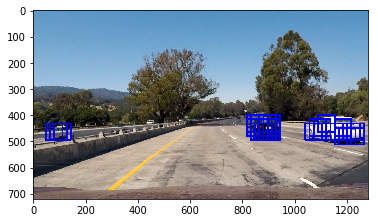

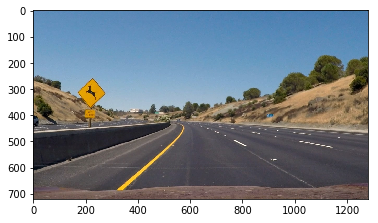

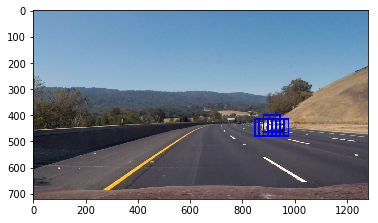

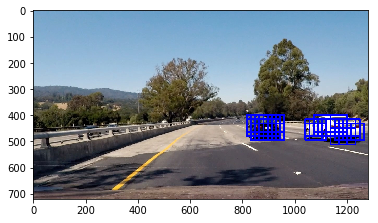

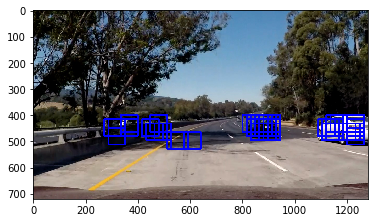

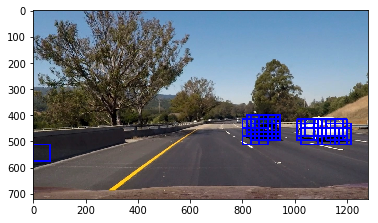

In [22]:
scale = 1

plt.imshow(find_cars(mpimg.imread('test_images/test1.jpg'), debug=False))
plt.show()
plt.imshow(find_cars(mpimg.imread('test_images/test2.jpg'), debug=False))
plt.show()
plt.imshow(find_cars(mpimg.imread('test_images/test3.jpg'), debug=False))
plt.show()
plt.imshow(find_cars(mpimg.imread('test_images/test4.jpg'), debug=False))
plt.show()
plt.imshow(find_cars(mpimg.imread('test_images/test5.jpg'), debug=False))
plt.show()
plt.imshow(find_cars(mpimg.imread('test_images/test6.jpg'), debug=False))
plt.show()

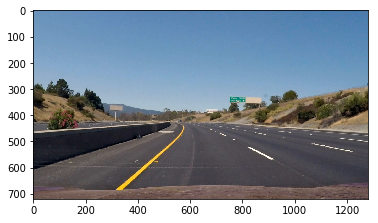

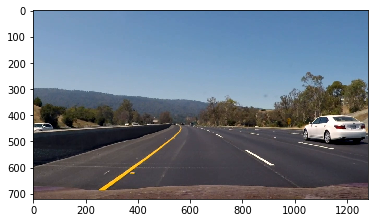

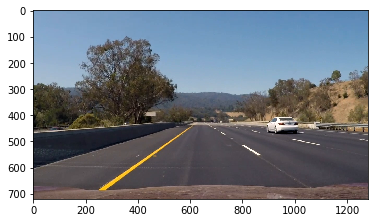

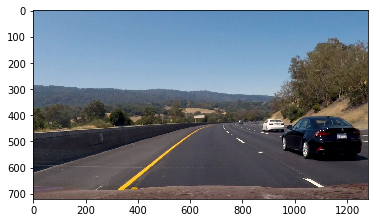

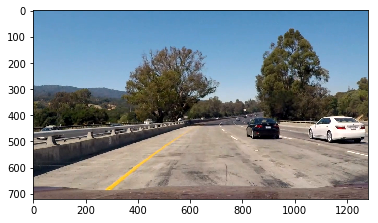

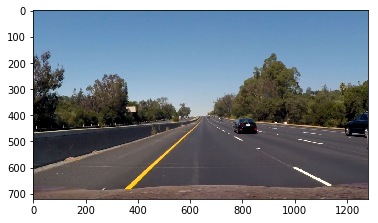

In [10]:
clip = VideoFileClip('project_video.mp4')
for frame in clip.iter_frames(fps=0.1):
    #result = process_frame(frame, debug=False)
    plt.imshow(frame)
    plt.show()